<a href="https://colab.research.google.com/github/renatostosp/aulas_redes_neurais_20231/blob/main/aula03c_multiclasse_renato_santos_pereira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>SEPARADORES LINEARES - PERCEPTRON IMPLEMENTADO EM AULA</h1>

In [14]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


def criaDatasetBidimensionalMulticlasse():
    """
    Cria um dataset bidimensional multiclasse
    a partir do PCA do IRIS com 2 componentes.
    """
    iris = load_iris()
    X = iris.data
    y = iris.target

    # Reduz a dimensão do Iris de 4 para 2 componentes
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    return X_reduced, y

X, y = criaDatasetBidimensionalMulticlasse()
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.9)

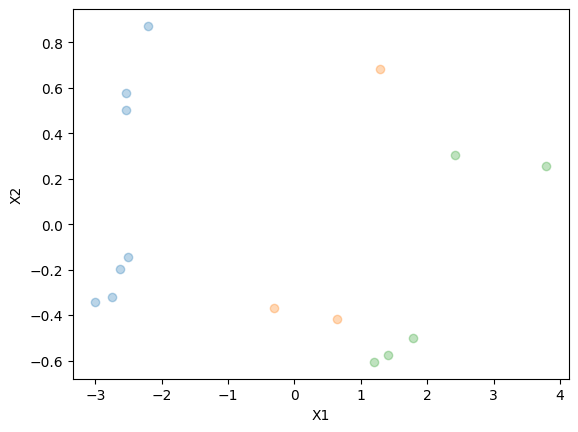

In [15]:
import matplotlib.pyplot as plt

def plotaDatasetBidimensional(X, y):
    """
    Plota um dataset bidimensional.
    """
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotaDatasetBidimensional(Xtr, ytr)

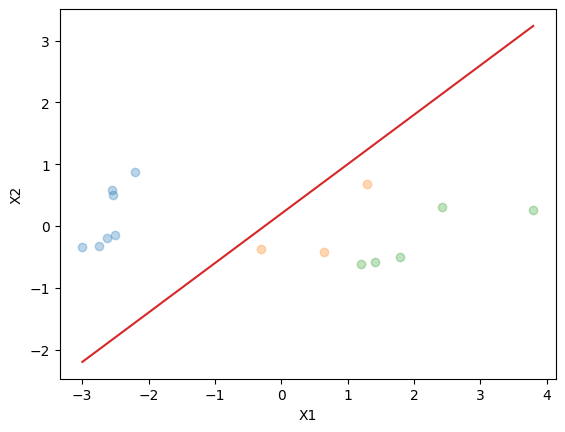

In [16]:
def plotaHiperplanoDatasetBidimensional(X, vetor, intercept=0):
    """
    Plota um definido por um
    vetor e o valor em que este vetor
    intercepta o eixo vertical.
    """
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - intercept / vetor[1]
    plt.plot(xs,ys)

plotaDatasetBidimensional(Xtr, ytr)
vetor_hyperplano = np.array([4, 5]) * np.array([1, -1])
plotaHiperplanoDatasetBidimensional(Xtr, vetor_hyperplano, 1)

In [17]:
def sign(a):
    return (a >= 0) * 2 - 1

def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

In [18]:
from abc import ABC, abstractstaticmethod

class Custo(ABC):
    @abstractstaticmethod
    def custo(y, ypred):
        pass
    @abstractstaticmethod
    def gradiente(y, ypred, X):
        pass

class WidrowHoff(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - (y * ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - ypred)

class SmoothedSurrogate(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - sign(ypred))

class HingeLoss(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    @staticmethod
    def gradiente(y, ypred, X):
        errosmarginais = (y * ypred) < 1
        ymarginais = np.copy(y)
        ymarginais[~errosmarginais] = 0
        g = X.T @ ymarginais
        return g

from scipy.special import expit

class LogLikelihood(Custo):
    @staticmethod
    def custo(y, ypred):
        return np.sum(np.log(1 + np.exp(- y * ypred)))
    @staticmethod
    def gradiente(y, ypred, X):
        return X.T @ (y - (expit(ypred)*2-1))

In [19]:
from abc import ABC, abstractmethod

class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self, X, y, activation):
    pass

class PseudoInversa(TrainingAlgorithm):
  def __init__(self, regularization=0):
    self.regularization = regularization
  def getW(self, X, y):
    return np.linalg.inv(X.T @ X + np.eye(X.shape[1])*self.regularization) @ X.T @ y


class DescidaGradiente(TrainingAlgorithm):
  def __init__(self, max_iter=100, learning_rate=0.05,
               regularization=0, cost=WidrowHoff()):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.regularization = regularization
    self.cost = cost

  def getW(self, X, y):
    w = np.random.uniform(-1, 1, size=(X.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = X @ w
      if self.cost.custo(y, ypred) == 0:
        break
      w *= 1 - self.regularization * self.learning_rate
      w += self.cost.gradiente(y, ypred, X) * self.learning_rate
    return w

0.9333333333333333
[[-2.41166759 -1.3748021  -3.71904972]
 [-2.97398255  0.23821427  3.07789633]
 [ 1.63132959  0.01285301 -2.68005865]]


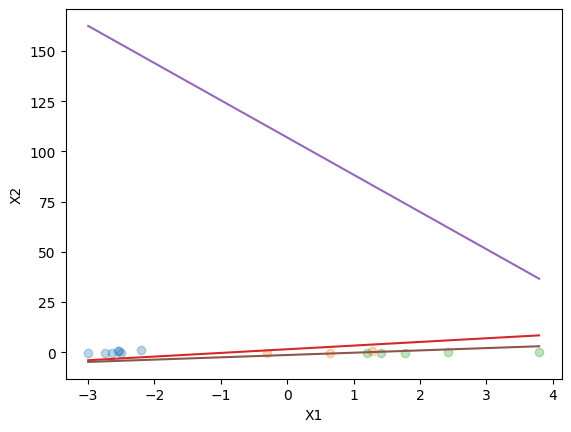

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

class Perceptron(BaseEstimator, ClassifierMixin):
  def __init__(self, training_algorithm=DescidaGradiente()):
    self.w = None
    self.training_algorithm = training_algorithm

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)*2-1

  def fit(self, X, y):
    Xb = include_bias(X)
    yhot = self.encode_labels(y)
    self.w = self.training_algorithm.getW(Xb, yhot)

  def __pre_activation(self, X):
    Xb = include_bias(X)
    return Xb @ self.w

  def predict(self, X):
    a = self.__pre_activation(X)
    if self.w.shape[1] == 1:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

perceptron = Perceptron(training_algorithm=DescidaGradiente(cost=LogLikelihood()))
perceptron.fit(Xtr, ytr)
print(accuracy(ytr, perceptron.predict(Xtr)))
print(perceptron.w)
plotaDatasetBidimensional(Xtr, ytr)

if perceptron.w.shape[1] == 1:
  plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:], perceptron.w[0])
else:
  for i in range(perceptron.w.shape[1]):
    plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])

0.8 0.6518518518518519
[[-0.22037054 -0.56977667 -0.20948451]
 [-0.40520235  0.07600526  0.32947669]
 [ 0.37239762  0.01150738 -0.37420963]]


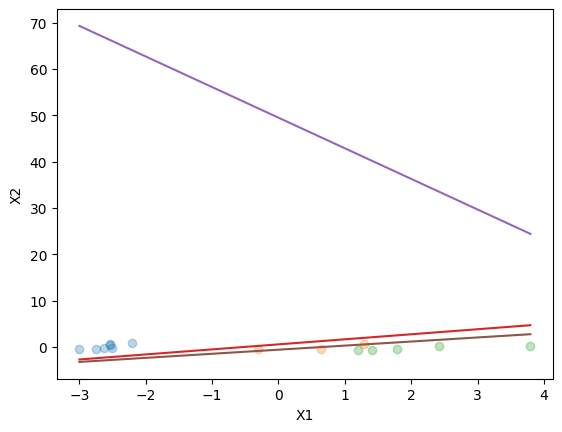

0.8 0.6518518518518519
[[-0.02758374 -0.2880363  -0.11443555]
 [-0.40171167  0.07749731  0.08264975]
 [ 0.75177877 -0.07227197 -0.04621067]]


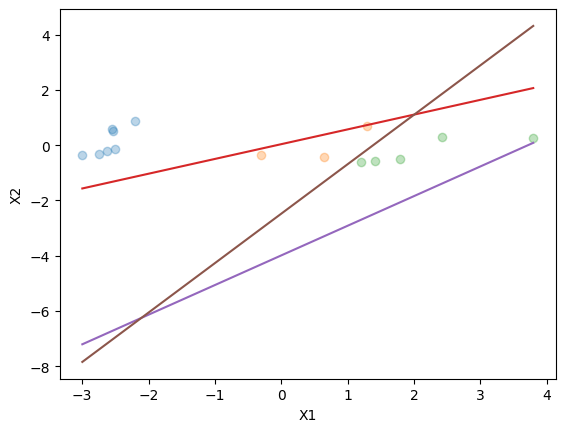

0.8 0.6518518518518519
[[-0.92527828 -1.10090078 -0.87728084]
 [-0.8395221   0.00204688  1.14381427]
 [ 0.44511663 -0.01280339 -0.45425976]]


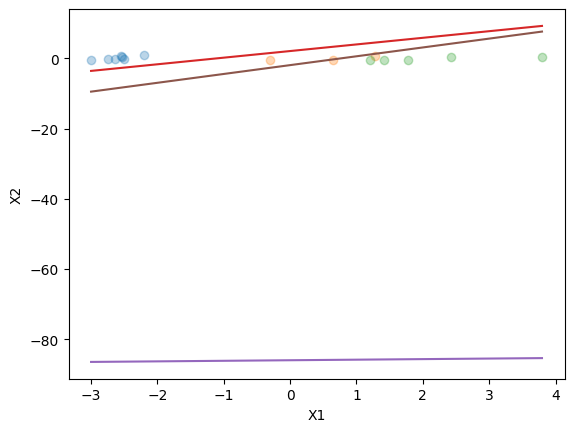

0.8 0.6518518518518519
[[-1.37613902 -1.36406727 -1.54305962]
 [-2.23560038  0.23685697  1.69313466]
 [-0.00366256 -0.02165165 -0.7888842 ]]


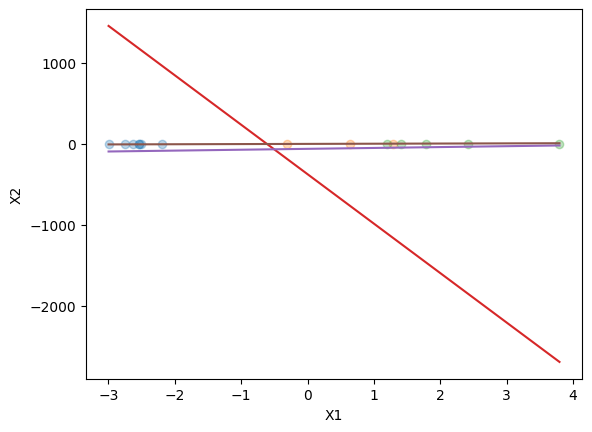

In [21]:
custos = [WidrowHoff(), SmoothedSurrogate(), HingeLoss(), LogLikelihood()]

for custo in custos:
    perceptron = Perceptron(training_algorithm=DescidaGradiente(learning_rate=0.01, regularization=0, cost=custo))
    perceptron.fit(Xtr, ytr)
    print(accuracy(ytr, perceptron.predict(Xtr)), accuracy(yte, perceptron.predict(Xte)))
    print(perceptron.w)
    plotaDatasetBidimensional(Xtr, ytr)
    if perceptron.w.shape[1] == 1:
            plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:], perceptron.w[0])
    else:
        for i in range(perceptron.w.shape[1]):
            plotaHiperplanoDatasetBidimensional(Xtr, perceptron.w[1:,i], perceptron.w[0,i])
    plt.show()

<h1>SEPARADORES LINEARES - SCIKIT-LEARN</h1>

Separador escolhido: SVM
https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html

Accuracy: 0.97


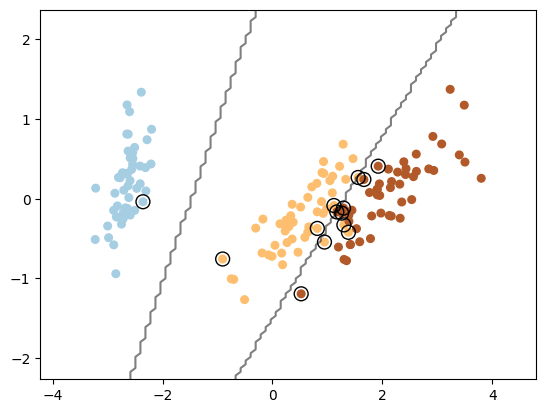

In [49]:
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay


# we create 40 separable points
X, y = criaDatasetBidimensionalMulticlasse()

# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=1000)
clf.fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    plot_method="contour",
    colors="k",
    levels=[-1, 0, 1],
    alpha=0.5,
    linestyles=["-", "-", "-"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)

# Predict the labels for the data points
y_pred = clf.predict(X)

# Calculate and print the accuracy
accuracy = clf.score(X, y)
print(f"Accuracy: {accuracy:.2f}")

plt.show()